In [101]:
from google_auth_oauthlib import flow
from google.cloud import bigquery
import datetime
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
from scipy.optimize import curve_fit
from tqdm.notebook import trange, tqdm
import math
import seaborn as sns

In [41]:
 config = {
    "installed": {
        "client_id": "331732725904-l8vvj4ud0grr3og2dfns85cfkdq9gajq.apps.googleusercontent.com",
        "project_id": "paint-by-number-3c789", "auth_uri": "https://accounts.google.com/o/oauth2/auth",
        "token_uri": "https://oauth2.googleapis.com/token",
        "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
        "client_secret": "Gr_NGbHFHUgbzZTDXHKAUYML",
        "redirect_uris": ["urn:ietf:wg:oauth:2.0:oob", "http://localhost"]
    }
}
 
app_flow = flow.InstalledAppFlow.from_client_config(
    config, scopes=[
        'https://www.googleapis.com/auth/bigquery'
    ]
)
app_flow.run_local_server()
 
credentials = app_flow.credentials
project_id = 'blockpuzzle-f21e1'
client = bigquery.Client(project=project_id, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=331732725904-l8vvj4ud0grr3og2dfns85cfkdq9gajq.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=DFu8lR15sKGr5NtygvkkjrsgTBqMgD&access_type=offline


<h2>数据处理</h2>

In [3]:
#生成所需sql
def get_sql(media_source, country):
    sql = f"""
    SELECT
        living_days,
        media_source,
        first_day_country,
        COUNT(distinct user_pseudo_id) as users,
        SUM(accumulated_revenue) as accumulated_revenue
    FROM
        (SELECT
            user_pseudo_id,
            media_source,
            first_day_country,
            living_days,
            SUM(ad_revenue) over(partition by user_pseudo_id ORDER BY living_days range between unbounded preceding and current row) as accumulated_revenue
        FROM `blockpuzzle-f21e1.warehouse.xinyao_temp_roi_everyday_revenue`
        WHERE media_source = '{media_source}'
        AND first_day_country = '{country}')
    GROUP BY 1,2,3
    ORDER BY 1,2,3
    """
    return sql

In [4]:
country = 'United States'
media_source = 'googleadwords_int'

In [5]:
sql = get_sql(media_source, country)
print(sql)


    SELECT
        living_days,
        media_source,
        first_day_country,
        COUNT(distinct user_pseudo_id) as users,
        SUM(accumulated_revenue) as accumulated_revenue
    FROM
        (SELECT
            user_pseudo_id,
            media_source,
            first_day_country,
            living_days,
            SUM(ad_revenue) over(partition by user_pseudo_id ORDER BY living_days range between unbounded preceding and current row) as accumulated_revenue
        FROM `blockpuzzle-f21e1.warehouse.xinyao_temp_roi_everyday_revenue`
        WHERE media_source = 'googleadwords_int'
        AND first_day_country = 'United States')
    GROUP BY 1,2,3
    ORDER BY 1,2,3
    


In [6]:
test = client.query(sql).result().to_dataframe()

In [7]:
test

,living_days,media_source,first_day_country,users,accumulated_revenue
0,0,googleadwords_int,United States,235584,15074.70
1,1,googleadwords_int,United States,234748,31084.07
2,2,googleadwords_int,United States,233554,42354.92
3,3,googleadwords_int,United States,232549,51478.03
4,4,googleadwords_int,United States,231739,59413.17
...,...,...,...,...,...
148,148,googleadwords_int,United States,20189,25259.72
149,149,googleadwords_int,United States,16395,20153.42
150,150,googleadwords_int,United States,12414,14968.72
151,151,googleadwords_int,United States,8266,9933.16


In [8]:
test['ltv'] = test['accumulated_revenue']/test['users']
test.head(10)

,living_days,media_source,first_day_country,users,accumulated_revenue,ltv
0,0,googleadwords_int,United States,235584,15074.70,0.063989
1,1,googleadwords_int,United States,234748,31084.07,0.132415
2,2,googleadwords_int,United States,233554,42354.92,0.181350
3,3,googleadwords_int,United States,232549,51478.03,0.221364
4,4,googleadwords_int,United States,231739,59413.17,0.256380
5,5,googleadwords_int,United States,230747,66441.04,0.287939
6,6,googleadwords_int,United States,229582,72786.39,0.317039
7,7,googleadwords_int,United States,228724,78810.74,0.344567
8,8,googleadwords_int,United States,227585,84054.56,0.369333
9,9,googleadwords_int,United States,226396,88928.23,0.392799


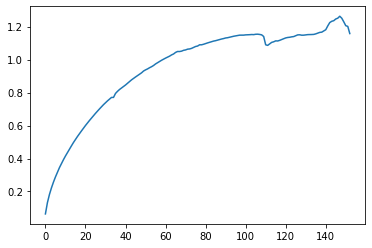

In [9]:
plt.plot(test['living_days'],test['ltv'])

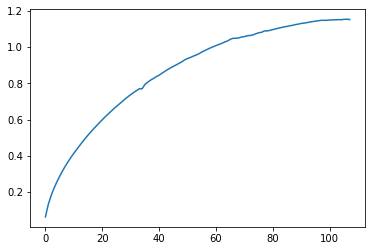

In [10]:
#截选可以用来训练的数据集
plt.plot(test[test['living_days']<108]['ltv'])

<h2>选择函数</h2>

In [11]:
x = test[test['living_days']<108]['living_days'].tolist()
y = test[test['living_days']<108]['ltv'].tolist()

In [64]:
def func1(x, a, b, c):
    return a*(x**0.5)+b*x+c

def func2(x, a, b):
    return a*(x**b)

def func3(x, a, b, c):
    return a*(x**0.7)+b*x+c

def func4(x, a, b):
    return a*np.log10(x)+b

In [73]:
def try_different_func(func, x, y):
    popt, pcov = curve_fit(func,x,y)
    two_hundred_day_ltv = func(200, *popt)
    print(func)
    print('ltv in 200 day is: ',two_hundred_day_ltv)
    
    print('ltv in 105 day is: ',func(105, *popt))
    print('ltv in 106 day is: ',func(106, *popt))
    print('ltv in 107 day is: ',func(107, *popt))
    
    y_predict= [func(i, *popt) for i in x]
    plt.plot(x,y,'b-')
    plt.plot(x,y_predict,'r--')
    plt.show()
    
    ss_res = np.sum(np.power([y[i] - y_predict[i] for i in range(len(y))],2))
    ss_tot = np.sum(np.power(y-np.mean(y),2))
    r_squared = 1 - (ss_res / ss_tot)
    print('R squared is: ',r_squared)
    
    return two_hundred_day_ltv

<function func1 at 0x7f912cdb69e0>
ltv in 200 day is:  1.3625999894019514
ltv in 105 day is:  1.1868334807536534
ltv in 106 day is:  1.1900564177881137
ltv in 107 day is:  1.1932383935803024
R squared is:  0.9941271417160169


1.3625999894019514

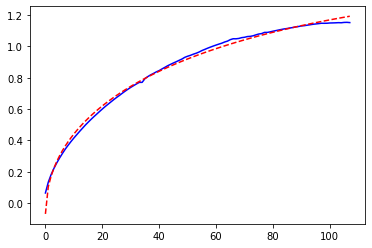

In [14]:
try_different_func(func1, x, y)

<function func2 at 0x7f912cdb6b00>
ltv in 200 day is:  1.5986702138321327
ltv in 105 day is:  1.2230663676913682
ltv in 106 day is:  1.227894270233956
ltv in 107 day is:  1.2326956294226328
R squared is:  0.9846712455820259


1.5986702138321327

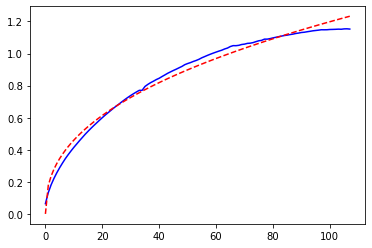

In [15]:
try_different_func(func2, x, y)

<function func3 at 0x7f912cdb6c20>
ltv in 200 day is:  1.1880305020352853
ltv in 105 day is:  1.1710017561020902
ltv in 106 day is:  1.1732051755229573
ltv in 107 day is:  1.1753506815033725
R squared is:  0.998640192685638


1.1880305020352853

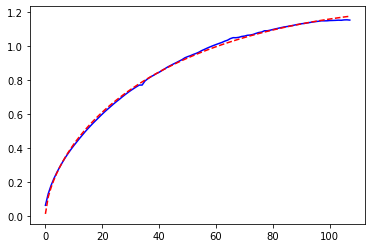

In [16]:
try_different_func(func3, x, y)

<h2>对比拟合值和真实值之间的差距</h2>

<function func3 at 0x7f912cdb6c20>
ltv in 200 day is:  1.2026426828059211
ltv in 105 day is:  1.1747247741730653
ltv in 106 day is:  1.1770233965140509
ltv in 107 day is:  1.1792646610350825
R squared is:  0.9987665521391073


1.2026426828059211

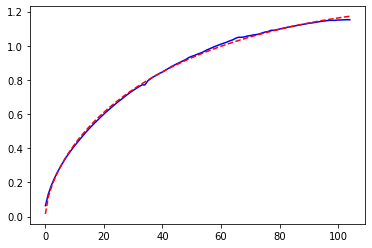

In [17]:
x_test = test[test['living_days']<105]['living_days'].tolist()
y_test = test[test['living_days']<105]['ltv'].tolist()
try_different_func(func3, x_test, y_test)

In [18]:
test[(test['living_days'] <= 107) & (test['living_days'] >= 105)]['ltv']

105    1.153795
106    1.154305
107    1.152689
Name: ltv, dtype: float64

<h3>最终函数选择：对数函数（func4），公式：
    $alog_{10}{x}+bx+c$</h3>

<h2>计算投放策略的天数</h2>

In [78]:
def get_ua_period(func, x, y, df):
    popt, pcov = curve_fit(func,x,y)
    two_hundred_day_ltv = func(365, *popt)
    safe_line = two_hundred_day_ltv * 0.8
#     print('Max living days is: ', df[(df['ltv'] >= safe_line)]['living_days'].head(1).tolist()[0])
    max_real_ltv = np.max(df['ltv'].tolist())
    if safe_line <= max_real_ltv:
        max_living_day = df[(df['ltv'] >= safe_line)]['living_days'].head(1).tolist()[0]
    else:
        y_predict= [func(i, *popt) for i in range(365)]
#         plt.plot(x,y,'b-')
#         plt.plot([i for i in range(365)],y_predict,'r--')
        i = 0
        while i < 365:
            if y_predict[i] >= safe_line:
                max_living_day = i - 1
                break
            else:
                i += 1
    return max_living_day,two_hundred_day_ltv,safe_line

In [21]:
country_list = ['Brazil','France','Spain','United States','Russia','Germany','Japan','Mexico','United Kingdom']
ms_list = ['Organic','Facebook Ads','ironsource_int','unityads_int','googleadwords_int']

In [25]:
#在理想情况下跑，数据运行速度较快的情况下可用
def get_diff_country_diff_ms_data(country_list, ms_list):
    result = []
    for i in tqdm(range(len(country_list))):
        for j in tqdm(range(len(ms_list))):
            sql = get_sql(ms_list[j],country_list[i])
            df = client.query(sql).result().to_dataframe()
            df['ltv'] = df['accumulated_revenue']/df['users']
            x = df[df['living_days']<108]['living_days'].tolist()
            y = df[df['living_days']<108]['ltv'].tolist()
            print(f'Country and media source: {country_list[i]}, {ms_list[j]}')
            max_living_day,two_hundred_day_ltv,safe_line = get_ua_period(func3, x, y, df)
            result.append([country_list[i],ms_list[j],max_living_day,two_hundred_day_ltv,safe_line])
    return pd.DataFrame(columns=['country','media_source','ua_period','200day_ltv','safe_line'],data=result)

<h2>手动输出</h2>

In [36]:
revenue_by_country_ms_sql = f"""
    SELECT
        living_days,
        media_source,
        first_day_country,
        COUNT(distinct user_pseudo_id) as users,
        SUM(accumulated_revenue) as accumulated_revenue
    FROM
        (SELECT
            user_pseudo_id,
            media_source,
            first_day_country,
            living_days,
            SUM(ad_revenue) over(partition by user_pseudo_id ORDER BY living_days range between unbounded preceding and current row) as accumulated_revenue
        FROM `blockpuzzle-f21e1.warehouse.xinyao_temp_roi_everyday_revenue`
        WHERE media_source in ('Organic','Facebook Ads','ironsource_int','unityads_int','googleadwords_int')
        AND first_day_country in ('Brazil','France','Spain','United States','Russia','Germany','Japan','Mexico','United Kingdom'))
    GROUP BY 1,2,3
    ORDER BY 1,2,3
    """

In [37]:
print(revenue_by_country_ms_sql)


    SELECT
        living_days,
        media_source,
        first_day_country,
        COUNT(distinct user_pseudo_id) as users,
        SUM(accumulated_revenue) as accumulated_revenue
    FROM
        (SELECT
            user_pseudo_id,
            media_source,
            first_day_country,
            living_days,
            SUM(ad_revenue) over(partition by user_pseudo_id ORDER BY living_days range between unbounded preceding and current row) as accumulated_revenue
        FROM `blockpuzzle-f21e1.warehouse.xinyao_temp_roi_everyday_revenue`
        WHERE media_source in ('Organic','Facebook Ads','ironsource_int','unityads_int','googleadwords_int')
        AND first_day_country in ('Brazil','France','Spain','United States','Russia','Germany','Japan','Mexico','United Kingdom'))
    GROUP BY 1,2,3
    ORDER BY 1,2,3
    


In [42]:
df = client.query(revenue_by_country_ms_sql).result().to_dataframe()
df['ltv'] = df['accumulated_revenue']/df['users']
df.head(3)

,living_days,media_source,first_day_country,users,accumulated_revenue,ltv
0,0,Facebook Ads,Brazil,890901,9891.66,0.011103
1,0,Facebook Ads,France,143351,3876.64,0.027043
2,0,Facebook Ads,Germany,84707,2802.82,0.033088


In [52]:
def get_ua_strategy(country_list, ms_list, df):
    result = []
    for i in tqdm(range(len(country_list))):
        for j in range(len(ms_list)):
            df_country_ms = df[(df['media_source']==ms_list[j])&(df['first_day_country']==country_list[i])]
            x = df_country_ms[df_country_ms['living_days']<108]['living_days'].tolist()
            y = df_country_ms[df_country_ms['living_days']<108]['ltv'].tolist()
#             print(f'Country and media source: {country_list[i]}, {ms_list[j]}')
            max_living_day,two_hundred_day_ltv,safe_line = get_ua_period(func3, x, y, df_country_ms)
            result.append([country_list[i],ms_list[j],max_living_day,two_hundred_day_ltv,safe_line])
    return pd.DataFrame(columns=['country','media_source','ua_period','200day_ltv','safe_line'],data=result)

,country,media_source,ua_period,200day_ltv,safe_line
0,Brazil,Organic,61,0.151756,0.121405
1,Brazil,Facebook Ads,39,0.133142,0.106514
2,Brazil,ironsource_int,79,0.158664,0.126932
3,Brazil,unityads_int,151,0.208922,0.167138
4,Brazil,googleadwords_int,26,0.095499,0.076399
5,France,Organic,65,0.431319,0.345056
6,France,Facebook Ads,46,0.411588,0.329270
7,France,ironsource_int,105,0.466996,0.373597
8,France,unityads_int,116,0.520733,0.416586
9,France,googleadwords_int,38,0.318575,0.254860


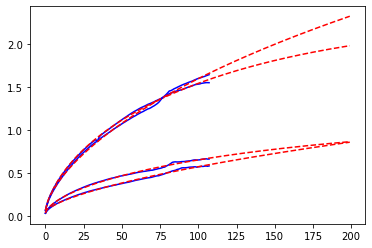

In [53]:
ua_strategy_result = get_ua_strategy(country_list, ms_list, df)
ua_strategy_result

<h2>针对异常数据检查</h2>

<function func4 at 0x7f912d529d40>
ltv in 200 day is:  0.1237488160665875
ltv in 105 day is:  0.10921225390821372
ltv in 106 day is:  0.10942609242812366
ltv in 107 day is:  0.10963792304496249
R squared is:  0.9732496399237238


0.1237488160665875

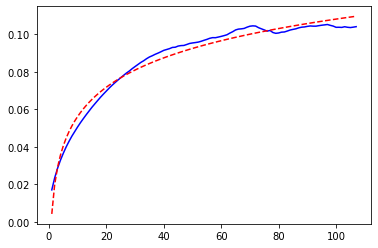

In [67]:
df_russia_googleadwords_int = df[(df['media_source']=='googleadwords_int')&(df['first_day_country']=='Russia')]
x_russia_googleadwords_int = df_russia_googleadwords_int[(df_russia_googleadwords_int['living_days']<108)&(df_russia_googleadwords_int['living_days']>0)]['living_days'].tolist()
y_russia_googleadwords_int = df_russia_googleadwords_int[(df_russia_googleadwords_int['living_days']<108)&(df_russia_googleadwords_int['living_days']>0)]['ltv'].tolist()
try_different_func(func4, x_russia_googleadwords_int, y_russia_googleadwords_int)

In [94]:
def get_ua_period_1(func, x, y, df):
    #长尾拟合时间限制
    est_days = 365
    
    popt, pcov = curve_fit(func,x,y)
    two_hundred_day_ltv = func(est_days, *popt)
    safe_line = two_hundred_day_ltv * 0.8
#     print('Max living days is: ', df[(df['ltv'] >= safe_line)]['living_days'].head(1).tolist()[0])
    max_real_ltv = np.max(df['ltv'].tolist())
    if safe_line <= max_real_ltv:
        max_living_day = df[(df['ltv'] >= safe_line)]['living_days'].head(1).tolist()[0]
    else:
        y_predict= [func(i, *popt) for i in range(1,est_days)]
#         plt.plot(x,y,'b-')
#         plt.plot([i for i in range(365)],y_predict,'r--')
        i = 1
        while i < est_days:
            if y_predict[i] >= safe_line:
                max_living_day = i - 1
                break
            else:
                i += 1
    return max_living_day,two_hundred_day_ltv,safe_line

In [95]:
def get_ua_strategy_check_every_step(country_list, ms_list, df):
    result = []
    for i in tqdm(range(len(country_list))):
        for j in range(len(ms_list)):
            df_country_ms = df[(df['media_source']==ms_list[j])&(df['first_day_country']==country_list[i])]
            x = df_country_ms[(df_country_ms['living_days']<108)&(df_country_ms['living_days']>0)]['living_days'].tolist()
            y = df_country_ms[(df_country_ms['living_days']<108)&(df_country_ms['living_days']>0)]['ltv'].tolist()
            
            # 检查每个国家和渠道的拟合情况
#             print(f'Country and media source: {country_list[i]}, {ms_list[j]}')
#             try_different_func(func4, x, y)
            
            # 计算ua所需要的天数
            max_living_day,two_hundred_day_ltv,safe_line = get_ua_period_1(func4, x, y, df_country_ms)
            result.append([country_list[i],ms_list[j],max_living_day,two_hundred_day_ltv,safe_line])
            
            # 如果拟合的不好的话退出函数
#             con = input('Whether continue? (y/n)')
#             if con == 'y':
#                 continue
#             else:
#                 return 'Break'

    return pd.DataFrame(columns=['country','media_source','ua_period','200day_ltv','safe_line'],data=result)

In [96]:
ua_strategy_result_2 = get_ua_strategy_check_every_step(country_list, ms_list, df)

In [97]:
ua_strategy_result_2

,country,media_source,ua_period,200day_ltv,safe_line
0,Brazil,Organic,122,0.183818,0.147054
1,Brazil,Facebook Ads,138,0.183717,0.146974
2,Brazil,ironsource_int,107,0.175111,0.140089
3,Brazil,unityads_int,96,0.176043,0.140834
4,Brazil,googleadwords_int,152,0.148919,0.119135
5,France,Organic,142,0.506160,0.404928
6,France,Facebook Ads,132,0.545895,0.436716
7,France,ironsource_int,104,0.465510,0.372408
8,France,unityads_int,109,0.504801,0.403841
9,France,googleadwords_int,152,0.445311,0.356249


<h2>计算自然量因子</h2>

In [98]:
new_user_sql = f"""
    SELECT
        create_date,
        media_source,
        first_day_country,
        COUNT(distinct user_pseudo_id) as new_users
    FROM `blockpuzzle-f21e1.warehouse.xinyao_temp_roi_everyday_revenue`
    WHERE first_day_country in ('Brazil','France','Spain','United States','Russia','Germany','Japan','Mexico','United Kingdom')
    GROUP BY 1,2,3
    ORDER BY 1,2,3
    """

In [99]:
nu = client.query(new_user_sql).result().to_dataframe()
nu.head(3)

,create_date,media_source,first_day_country,new_users
0,2020-04-01,None,Brazil,912
1,2020-04-01,None,France,71
2,2020-04-01,None,Germany,95


<h3>使用美国测试</h3>

In [100]:
nu[nu['first_day_country']=='United States']

,create_date,media_source,first_day_country,new_users
8,2020-04-01,None,United States,215
17,2020-04-01,Facebook Ads,United States,4662
26,2020-04-01,Organic,United States,1798
28,2020-04-01,Twitter,United States,4
34,2020-04-01,adcolony_int,United States,224
...,...,...,...,...
12815,2020-08-31,googleadwords_int,United States,861
12824,2020-08-31,ironsource_int,United States,414
12830,2020-08-31,mintegral_int,United States,23
12839,2020-08-31,restricted,United States,102


<h4>分渠道用户量和自然量散点图</h4>

In [113]:
nu['create_date'].nunique()

153

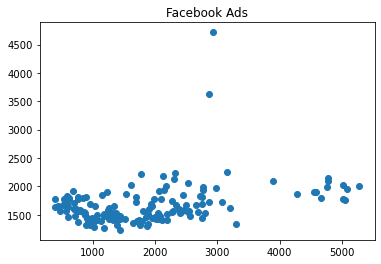

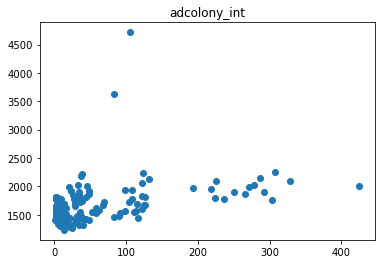

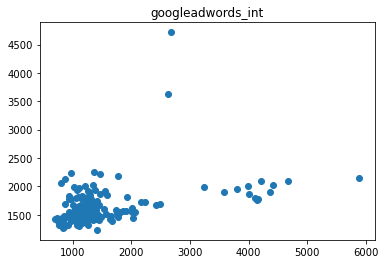

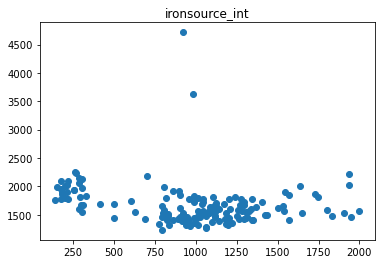

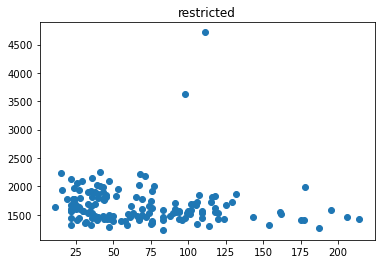

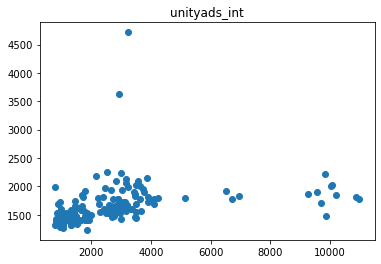

In [116]:
ms_list = nu[(nu['first_day_country']=='United States')]['media_source'].unique().tolist()
nu_us = nu[(nu['first_day_country']=='United States')]
for i in tqdm(range(len(ms_list))):
    if nu_us[nu_us['media_source']==ms_list[i]]['create_date'].nunique() == 153 and ms_list[i] != 'Organic':
        plt.title(ms_list[i])
        plt.scatter(nu_us[nu_us['media_source']==ms_list[i]]['new_users'],nu_us[nu_us['media_source']=='Organic']['new_users'])
        plt.show()

<h3>自然量因子结论：渠道投放量和自然量之间无显著相关性</h3>

<h2>计算自然量buffer</h2>

In [117]:
ua_strategy_result_2.head(10)

,country,media_source,ua_period,200day_ltv,safe_line
0,Brazil,Organic,122,0.183818,0.147054
1,Brazil,Facebook Ads,138,0.183717,0.146974
2,Brazil,ironsource_int,107,0.175111,0.140089
3,Brazil,unityads_int,96,0.176043,0.140834
4,Brazil,googleadwords_int,152,0.148919,0.119135
5,France,Organic,142,0.506160,0.404928
6,France,Facebook Ads,132,0.545895,0.436716
7,France,ironsource_int,104,0.465510,0.372408
8,France,unityads_int,109,0.504801,0.403841
9,France,googleadwords_int,152,0.445311,0.356249


In [148]:
for country in country_list:
    df_country = nu[(nu['media_source']=='Organic')&(nu['first_day_country']==country)]
    organic_user = np.average(df_country['new_users'])
#     print(organic_user)
    organic_ltv = ua_strategy_result_2[(ua_strategy_result_2['country']==country)&(ua_strategy_result_2['media_source']=='Organic')]['safe_line']
    organic_ltv = organic_ltv.tolist()[0]
#     print(organic_ltv)
    organic_buffer = organic_user * organic_ltv
    print(country, organic_buffer)
    
    ua_strategy_result_2['organic_buffer'] = ua_strategy_result_2.apply(lambda x: organic_buffer*0.8
                                                                        if x.country==country and x.media_source == 'googleadwords_int'
                                                                        else organic_buffer*0.2
                                                                        if x.country==country and x.media_source == 'Facebook Ads'
                                                                        else x.organic_buffer
                                                                        if x.organic_buffer != None
                                                                        else None, axis=1)

Brazil 552.4852347696556
France 289.8012829195134
Spain 107.90985781459237
United States 2613.492393227758
Russia 273.0284034388349
Germany 605.5921321254328
Japan 373.71019178417237
Mexico 81.22920961467472
United Kingdom 231.63005536547777


<h3>最终输出：ua_strategy_result_2</h3>

In [152]:
ua_strategy_result_2 = ua_strategy_result_2.rename(columns={"200day_ltv": "365day_ltv"})
ua_strategy_result_2

,country,media_source,ua_period,365day_ltv,safe_line,organic_buffer
0,Brazil,Organic,122,0.183818,0.147054,NaN
1,Brazil,Facebook Ads,138,0.183717,0.146974,110.497047
2,Brazil,ironsource_int,107,0.175111,0.140089,NaN
3,Brazil,unityads_int,96,0.176043,0.140834,NaN
4,Brazil,googleadwords_int,152,0.148919,0.119135,441.988188
5,France,Organic,142,0.506160,0.404928,NaN
6,France,Facebook Ads,132,0.545895,0.436716,57.960257
7,France,ironsource_int,104,0.465510,0.372408,NaN
8,France,unityads_int,109,0.504801,0.403841,NaN
9,France,googleadwords_int,152,0.445311,0.356249,231.841026


In [153]:
ua_strategy_result_2.to_csv('ua_strategy_result.csv')